In [1]:
import sys

import pandas as pd
import time
import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from nanoHUB.application import Application

application = Application.get_instance()
nanohub_db = application.new_db_engine('nanohub')
nanohub_metrics_db = application.new_db_engine('nanohub_metrics')
wang159_myrmekes_db = application.new_db_engine('rfm_data')

salesforce = application.new_salesforce_engine()
db_s = salesforce

nanoHUB - Serving Students, Researchers & Instructors
Obtained Salesforce access token ...... True


## Nanohub user growth

In [4]:
## need 
# 1) jos_users from nanohub with id,name,username,email,registerDate,lastvisitDate -> registered users
# 2) toolstart df filtered by username -> simulation users

# x-axis: each month from 2000 to current_year

# y-axis: 12 month trailing sum

# simulation users: unique users who have run at least 1 simulation

# registered users: new user registeration

# visitor count: unique IP address

In [5]:
## build jos_users_full
sql_query = "select id,name,username,email,registerDate,lastvisitDate from jos_users order by registerDate desc"
jos_users_full = pd.read_sql_query(sql_query, nanohub_db)
display(jos_users_full.head(2))
print(jos_users_full.shape)

,id,name,username,email,registerDate,lastvisitDate
0,356680,王鸣雁,-193187,-193187@invalid,2022-02-12 02:27:35,2022-02-12 02:27:36
1,356679,Mahdi Salari,mahdisalari82020,mahdisalari82020@gmail.com,2022-02-12 02:18:29,2022-02-12 02:18:30


(272691, 6)


In [6]:
 ## build all users list
sql_query = "select datetime,ip,countryip,user,tool from toolstart where user != 'instanton' "\
+"and user != 'gridstat' and datetime <= '2002-01-01' and datetime >= '0000-01-01' order by datetime desc"
toolstart_df = pd.read_sql_query(sql_query, nanohub_metrics_db)
display(toolstart_df.head(2))
print(toolstart_df.shape)

,datetime,ip,countryip,user,tool
0,2001-12-31 23:23:51,68.32.42.69,US,jjeon,Adeptf
1,2001-12-31 23:23:23,68.32.42.69,US,jjeon,Adeptf


(138857, 5)


In [7]:
## convert the dataframes to datetime
jos_users_full['registerDate'] = pd.to_datetime(jos_users_full.registerDate)
jos_users_full['lastvisitDate'] = pd.to_datetime(jos_users_full.lastvisitDate)

toolstart_df['datetime'] = pd.to_datetime(toolstart_df.datetime)

In [8]:
import datetime
today = datetime.datetime.now()
print(today)

2022-02-17 15:31:23.523246


In [9]:
all_months_list = list()
for this_year in range(2000,today.year+2):
    for this_month in range(1,12+1):
        all_months_list.append(datetime.datetime(this_year, this_month, 1))
        
for this_year in range(today.year,today.year+2):
    for this_month in range(1,today.month+1):
        all_months_list.append(datetime.datetime(this_year, this_month, 1))
        
months_bin = pd.DataFrame(all_months_list, columns=['year_month'])

# display
months_bin.head(2)

,year_month
0,2000-01-01
1,2000-02-01


In [10]:
## jos_users_full registration cumulative monthly
months_bin['registered_12_trail'] = months_bin.year_month.apply(lambda x:  \
                                jos_users_full.username[(jos_users_full.registerDate < x)\
                            &(jos_users_full.registerDate > (x-datetime.timedelta(days=365)))].nunique() )

In [11]:
##the all users must be done in a bi-yearly basis
months_bin['sim_12_trail'] = months_bin.year_month.apply(lambda x: toolstart_df.user[(toolstart_df.datetime < x) \
                                        &(toolstart_df.datetime > (x-datetime.timedelta(days=365)))].nunique() )

In [12]:
print(months_bin['year_month'].to_list().index(pd.to_datetime('2002-01-01')) )
temp = months_bin['sim_12_trail']#[:25]

24


In [13]:
## check if cached data is available locally
import os
cwd = os.getcwd()

In [14]:
try:
    months_bin2 = pd.read_csv(cwd+'/cached_data/nh_user_growth.csv')
    months_bin2['year_month'] = pd.to_datetime(months_bin2['year_month'],format='%Y-%m-%d')
    data_flag = True
except:
    data_flag = False
print(data_flag)

True


In [15]:
from copy import deepcopy

In [16]:
if data_flag == False: # need to gather all data
    start_year = 2002 # 2000 and 2001 done above 
else:
    test_df = months_bin2
    test_df = test_df[~(test_df.duplicated(subset=['sim_12_trail'], keep='last') & test_df['sim_12_trail'].eq(0))]
    test_df.index = pd.RangeIndex(len(test_df.index))
    start_year = (test_df.loc[1, 'year_month']).year
    print(start_year)

2000


In [17]:
months_bin3 = months_bin.iloc[months_bin['year_month'].to_list().index(months_bin2['year_month'].to_list()[-1])+1:,:]
months_bin4 = pd.concat([months_bin2,months_bin3])
months_bin = deepcopy(months_bin4)

if data_flag == False: # need to gather all data
    start_year = 2002 # 2000 and 2001 done above 
else:
    ts12 = months_bin2['sim_12_trail'].to_list()
    ## find all consecutive 0s in sim_12_trail
    con0s = [] # indexes of the start of the consecutive zeros
    for t_ind,t_val in enumerate(ts12):
        con_flag = False
        if t_ind > 0:
            con_flag = (ts12[t_ind-1]==0) and (t_val==0)
        if con_flag == True:
            con0s.append(t_ind-1)
#     con0s[1] # this should be the new start year
#     start_year = months_bin2['year_month'].to_list()[-1].year
    start_year = months_bin2['year_month'].to_list()[con0s[1]].year-1
    months_bin3 = months_bin.iloc[months_bin['year_month'].to_list().index(months_bin2['year_month'].to_list()[-1])+1:,:]
    months_bin4 = pd.concat([months_bin2,months_bin3])
    months_bin = deepcopy(months_bin4)
    
    # join months_bin and months_bin2
#     months_bin2['year_month'] = deepcopy(months_bin['year_month'])
#     months_bin = deepcopy(months_bin2)

In [18]:
months_bin = months_bin.drop(columns=['Unnamed: 0'])
display(months_bin.head(2))
display(months_bin.tail(2))

,year_month,registered_12_trail,sim_12_trail,visitors_12_trail
0,2000-01-01,15,0,0.0
1,2000-02-01,19,0,0.0


,year_month,registered_12_trail,sim_12_trail,visitors_12_trail
290,2023-01-01,4839,0,NaN
291,2023-02-01,1209,0,NaN


In [19]:
try:
    temp = pd.read_csv(cwd+'/cached_data/toolstarts_by_year_month.csv')
    print('Found cached file')
except:
    while start_year < today.year+1:
        prev_temp_ind = months_bin['year_month'].to_list().index(pd.to_datetime(str(start_year)+'-01-01')) 

        start_year += 1
        end_date = r"'"+str(start_year)+r"-01-01'"
        start_date = r"'"+str(start_year-2)+r"-01-01'"

        sql_query = "select datetime,ip,countryip,user,tool from toolstart where user != 'instanton' "\
            +"and user != 'gridstat' and datetime <= "+end_date+" and datetime >= "+start_date+" order by datetime desc"
        toolstart_df = pd.read_sql_query(sql_query, nanohub_metrics_db)
        toolstart_df['datetime'] = pd.to_datetime(toolstart_df.datetime)
        print(start_date, end_date)
        print(toolstart_df.shape)

        temp2 = months_bin.year_month.apply(lambda x: toolstart_df.user[(toolstart_df.datetime < x) \
                                            &(toolstart_df.datetime > (x-datetime.timedelta(days=365)))].nunique() )

        max_temp_ind = months_bin['year_month'].to_list().index(pd.to_datetime(str(start_year)+'-01-01')) 

        temp[prev_temp_ind:max_temp_ind] = temp2[prev_temp_ind:max_temp_ind] #updates months_bin as pointer effect

    temp.to_csv(cwd+'/cached_data/toolstarts_by_year_month.csv', index=None)
    
print(temp)

Found cached file
     sim_12_trail
0               0
1               0
2             133
3             199
4             244
..            ...
287             0
288             0
289             0
290             0
291             0

[292 rows x 1 columns]


In [20]:
months_bin['sim_12_trail'] = deepcopy(temp)

In [21]:
months_bin.iloc[:-55,:]

,year_month,registered_12_trail,sim_12_trail,visitors_12_trail
0,2000-01-01,15,0,0.0
1,2000-02-01,19,0,0.0
2,2000-03-01,24,133,0.0
3,2000-04-01,26,199,0.0
4,2000-05-01,30,244,0.0
...,...,...,...,...
232,2019-05-01,24300,17453,1480975.0
233,2019-06-01,24604,17370,1487253.0
234,2019-07-01,24641,17350,1490924.0
235,2019-08-01,24713,17121,1496080.0


In [22]:
display(months_bin.tail())

,year_month,registered_12_trail,sim_12_trail,visitors_12_trail
287,2023-12-01,0,0,NaN
288,2022-01-01,31354,0,NaN
289,2022-02-01,32334,0,NaN
290,2023-01-01,4839,0,NaN
291,2023-02-01,1209,0,NaN


In [23]:
# months_bin['year_month'].to_list()[-32:] #12 + today.month

In [24]:
if data_flag == True: 
    months_bin2 = months_bin.iloc[:months_bin.shape[0]-(1*24+today.month),:]

In [25]:
display(months_bin2.tail(5))

,year_month,registered_12_trail,sim_12_trail,visitors_12_trail
261,2021-10-01,31297,23481,1872976.0
262,2021-11-01,30870,23032,1947336.0
263,2021-12-01,30955,23071,1923533.0
264,2022-01-01,31354,22314,2040179.0
265,2022-02-01,32334,22711,2059461.0


In [26]:
# calculating total number of visitors
import json
with open(cwd+'/visitors.json') as f: # obtain visitors.json from https://nanohub.org/usage and viewing page source at lines 273-278
    visitor_dict = f.read()
    visitor_dict = visitor_dict.replace("\'",'\"')
    visitor_dict = json.loads(visitor_dict)

In [27]:
import re
pattern = re.compile('\d+]')
step1 = re.findall(pattern,visitor_dict['data'])
res_visitors = [i[:-1] for i in step1]

In [28]:
import numpy as np
res_visitors2 = list(np.zeros(12*6+14)) + res_visitors

In [29]:
print(len(res_visitors2))
print(res_visitors2[-5:])

268
['1872976', '1947336', '1923533', '2040179', '2059461']


In [30]:
months_bin2

,year_month,registered_12_trail,sim_12_trail,visitors_12_trail
0,2000-01-01,15,0,0.0
1,2000-02-01,19,0,0.0
2,2000-03-01,24,133,0.0
3,2000-04-01,26,199,0.0
4,2000-05-01,30,244,0.0
...,...,...,...,...
261,2021-10-01,31297,23481,1872976.0
262,2021-11-01,30870,23032,1947336.0
263,2021-12-01,30955,23071,1923533.0
264,2022-01-01,31354,22314,2040179.0


In [31]:
while months_bin2.shape[0] < len(res_visitors2):
    res_visitors2 = res_visitors2[1:]
# display(months_bin.iloc[-20:-10,:])

In [32]:
months_bin2['visitors_12_trail'] = res_visitors2

In [33]:
months_bin = deepcopy(months_bin2)

In [34]:
months_bin.shape

(266, 4)

In [35]:
months_bin.to_csv(cwd+'/cached_data/nh_user_growth.csv')
print('latest data cached')

latest data cached


In [36]:
months_bin

,year_month,registered_12_trail,sim_12_trail,visitors_12_trail
0,2000-01-01,15,0,0.0
1,2000-02-01,19,0,0.0
2,2000-03-01,24,133,0.0
3,2000-04-01,26,199,0.0
4,2000-05-01,30,244,0.0
...,...,...,...,...
261,2021-10-01,31297,23481,1872976
262,2021-11-01,30870,23032,1947336
263,2021-12-01,30955,23071,1923533
264,2022-01-01,31354,22314,2040179


In [37]:
with open(cwd+'/dev_flags.txt','r') as f:
    raw_flags = f.read()
flag_pattern = re.compile(r'= \w+')
flags1 = re.findall(flag_pattern,raw_flags)    
flags_result = [i[2:] for i in flags1]
dev_flag = flags_result[0]
prod_flag = flags_result[1]

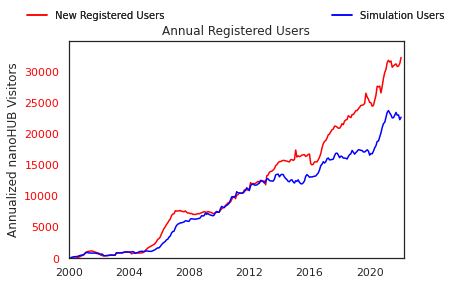

In [64]:
from matplotlib import pyplot as plt
import seaborn as sns
import os
sns.set()
sns.set_style("white")
#plt.figure(figsize=(9,6))
fig, ax1 = plt.subplots()
ax1.clear()
ax1.plot(months_bin.year_month[:], months_bin.registered_12_trail[:], color='red', label='New Registered Users');
ax1.plot(months_bin.year_month[:], months_bin.sim_12_trail[:], color='blue', label='Simulation Users');
#plt.plot(months_bin.year_month,res_visitors2)

ax1.set_title('Annual Registered Users')

ax1.set_xlim([datetime.datetime(2000,1,1), datetime.datetime(2022,4,1)]);
ax1.set_ylim([0, 35000])
ax1.set_yticks(np.arange(0,35000,5000))
ax1.tick_params(axis='y',labelcolor='red')
# ax1.set_ylabel('Unique Users/Month')

plt.ylabel('Annualized nanoHUB Visitors');
ax1.legend(loc='upper left');
ax1.legend()


h,l = ax1.get_legend_handles_labels()
# h2,l2 = ax2.get_legend_h
kw = dict(ncol=3,loc = 'lower center',frameon=False)
#(x, y, width, height)
#h += h2
#l += l2
leg1 = ax1.legend(h,l,bbox_to_anchor=(-0.15,1.05,1.3,0.2),\
                mode='expand',fontsize=10,**kw)
ax1.add_artist(leg1)

cwd = os.getcwd()
if dev_flag == 'True':
    plt.savefig(cwd+'/plots_local/300dpi_users_registrered_simulation_12_months.eps', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/300dpi_users_registrered_simulation_12_months.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/300dpi_users_registrered_simulation_12_months.png', dpi=300, bbox_inches='tight')
elif prod_flag == 'True':
    plt.savefig(cwd+'/plots_production/300dpi_users_registrered_simulation_12_months.eps', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/300dpi_users_registrered_simulation_12_months.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/300dpi_users_registrered_simulation_12_months.png', dpi=300, bbox_inches='tight')
else:
    print('no printing flag is active')

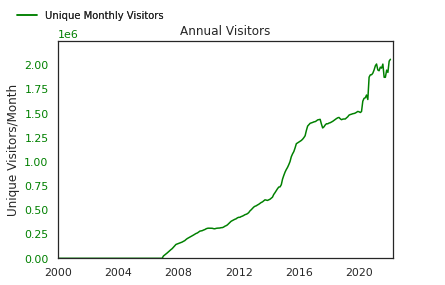

In [63]:
from matplotlib import pyplot as plt
import seaborn as sns
import os
sns.set()
sns.set_style("white")
#plt.figure(figsize=(9,6))
fig, ax1 = plt.subplots()

ax1.clear()
ax1.plot(months_bin.year_month[:],months_bin.visitors_12_trail[:],color='green',label='Unique Monthly Visitors')


ax1.set_title('Annual Visitors')

ax1.set_xlim([datetime.datetime(2000,1,1), datetime.datetime(2022,4,1)]);

ax1.set_ylabel('Unique Visitors/Month')
ax1.tick_params(axis='y',labelcolor='green')
ax1.set_ylim([0,2000000+250000])
ax1.set_yticks(np.arange(0,2000000+250000,250000))


ax1.legend()
# ax1.legend(loc='upper left')


h,l = ax1.get_legend_handles_labels()
kw = dict(ncol=3,loc = 'lower center',frameon=False)
#(x, y, width, height)
#h += h2
#l += l2
leg1 = ax1.legend(h,l,bbox_to_anchor=(-0.15,1.05,1.3,0.2),\
                mode='expand',fontsize=10,**kw)
ax1.add_artist(leg1)

cwd = os.getcwd()

if dev_flag == 'True':
    plt.savefig(cwd+'/plots_local/300dpi_users_unique_annual_visitors.eps', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/300dpi_users_unique_annual_visitors.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/300dpi_users_unique_annual_visitors.png', dpi=300, bbox_inches='tight')
elif prod_flag == 'True':
    plt.savefig(cwd+'/plots_production/300dpi_users_unique_annual_visitors.eps', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/300dpi_users_unique_annual_visitors.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/300dpi_users_unique_annual_visitors.png', dpi=300, bbox_inches='tight')
else:
    print('no printing flag is active')
